In [1]:
import json
import math
import os,cv2
from PIL import Image
import numpy as np 
import pandas as pd 
import tensorflow  as tf
from keras import layers
from keras.applications.densenet import DenseNet201
from keras.callbacks import Callback,ModelCheckpoint,ReduceLROnPlateau,TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score,accuracy_score
from tqdm import tqdm
from sklearn import metrics
from collections import Counter
import itertools 

In [2]:
def dataset_loader(DIR,ReSIZE,sigmaX =10):
  IMG = []
  read = lambda imname: np.asarray(Image.open(imname).convert('RGB'))
  for IMAGE_NAME in tqdm(os.listdir(DIR)):
    PATH = os.path.join(DIR,IMAGE_NAME)
    _,ftype = os.path.splitext(PATH)
    if ftype == '.png':
      img = read(PATH)

      img = cv2.resize(img,(ReSIZE,ReSIZE))

      IMG.append(np.array(img))
  return IMG

benign = np.array(dataset_loader('/content/drive/MyDrive/Data Science Projects/Breast cancer Classification/Breast+Cancer+Dataset+Small+-partial-/benign',224))
malign = np.array(dataset_loader('/content/drive/MyDrive/Data Science Projects/Breast cancer Classification/Breast+Cancer+Dataset+Small+-partial-/malign',224))


100%|██████████| 127/127 [00:08<00:00, 14.35it/s]


Create an independent and dependent features

In [3]:
benign_label = np.zeros(len(benign))
malign_label = np.zeros(len(malign))


In [4]:
X = np.concatenate((benign,malign),axis=0)
Y = np.concatenate((benign_label,malign_label),axis=0)

In [5]:
# Shuffling the data 

s = np.arange(X.shape[0])
np.random.shuffle(s)
X = X[s]
Y = Y[s]

Y = to_categorical(Y,num_classes=2)


In [6]:
x_train,x_val,y_train,y_val = train_test_split(X,Y,test_size=0.2,random_state=42)

In [7]:
w = 60
h =40
fig = plt.figure(figsize=(15,15))
columns = 4
rows = 3

for i in range(1,columns*rows + 1):
  ax = fig.add_subplot(rows,columns,i)
  if np.argmax(Y[i])==0:
    ax.title.set_text('Benign')
  else:
    ax.title.set_text('Malign')
  
  plt.imshow(x_train[i],interpolation='nearest')
plt.show()


Output hidden; open in https://colab.research.google.com to view.

# Image Preprocessing part 

In [8]:
BATCH_SIZE = 16
train_gen = ImageDataGenerator(
    zoom_range=2,
    rotation_range=90,
    horizontal_flip=True,
    vertical_flip=True,
)

In [9]:
def build_model(backbone,learning_rate=1e-3):
  model = Sequential()
  model.add(backbone)
  model.add(layers.GlobalAveragePooling2D())
  model.add(layers.Dropout(0.5))
  model.add(layers.BatchNormalization())
  model.add(layers.Dense(2,activation='softmax'))

  model.compile(
      loss= 'binary_crossentropy',
      optimizer=Adam(learning_rate=learning_rate),
      metrics = ['accuracy']
  )
  return model 

  # Import Our DenseNet201 model
resnet = DenseNet201(
      weights='imagenet',
      include_top=False,
      input_shape = (224,224,3)
 )

model = build_model(resnet,learning_rate=1e-4)
model.summary()



74836368/74836368 [==============================] - 5s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 7, 7, 1920)        18321984  
                                                                 
 global_average_pooling2d (G  (None, 1920)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1920)              0         
                                                                 
 batch_normalization (BatchN  (None, 1920)             7680      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 2)                 3842      
                                                         

In [10]:
learn_control = ReduceLROnPlateau(monitor='val_acc',patience=5,verbose=1,factor=0.2,min_lr=1e-7)

history = model.fit(
    train_gen.flow(x_train,y_train,batch_size=BATCH_SIZE),
    steps_per_epoch=x_train.shape[0] / BATCH_SIZE,
    epochs=7,
    validation_data=(x_val,y_val),
)

Epoch 1/7
11/11 [==============================] - 57s 2s/step - loss: 0.7829 - accuracy: 0.4817 - val_loss: 0.7418 - val_accuracy: 0.5208
Epoch 2/7
11/11 [==============================] - 4s 309ms/step - loss: 0.7620 - accuracy: 0.5393 - val_loss: 0.6305 - val_accuracy: 0.8750
Epoch 3/7
11/11 [==============================] - 5s 408ms/step - loss: 0.7357 - accuracy: 0.5969 - val_loss: 0.6221 - val_accuracy: 0.7708
Epoch 4/7
11/11 [==============================] - 4s 305ms/step - loss: 0.7060 - accuracy: 0.6073 - val_loss: 0.6681 - val_accuracy: 0.6458
Epoch 5/7
11/11 [==============================] - 4s 317ms/step - loss: 0.6935 - accuracy: 0.6230 - val_loss: 0.5855 - val_accuracy: 0.8125
Epoch 6/7
11/11 [==============================] - 6s 469ms/step - loss: 0.6584 - accuracy: 0.6702 - val_loss: 0.5511 - val_accuracy: 0.8958
Epoch 7/7
11/11 [==============================] - 4s 311ms/step - loss: 0.6234 - accuracy: 0.7068 - val_loss: 0.4786 - val_accuracy: 0.9792


In [11]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

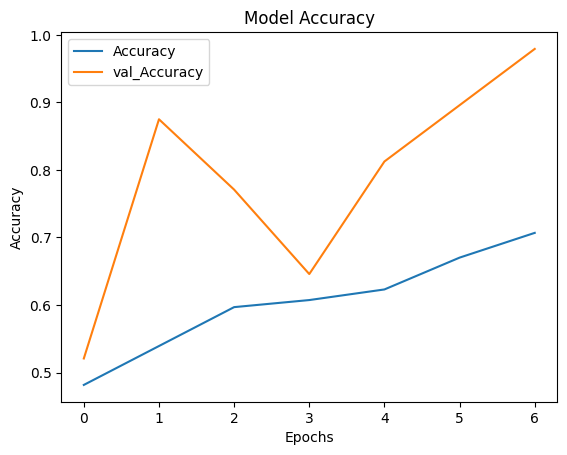

In [14]:
plt.plot(history.history['accuracy'],label = 'Accuracy')
plt.plot(history.history['val_accuracy'],label = 'val_Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


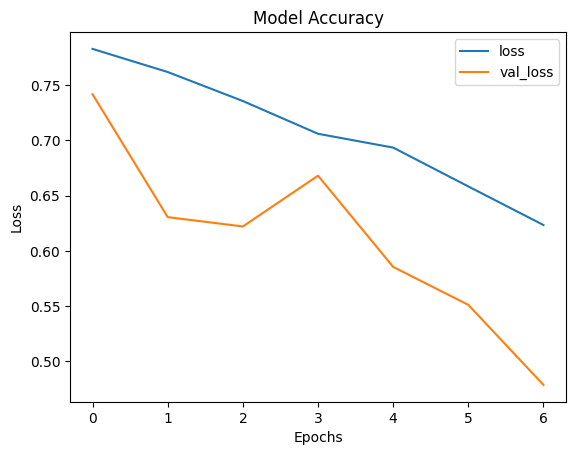

In [15]:
plt.plot(history.history['loss'],label = 'loss')
plt.plot(history.history['val_loss'],label = 'val_loss')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [16]:
# save the model

import pickle
pickle.dump(train_gen,open('/content/drive/MyDrive/Data Science Projects/Breast cancer Classification/image-generator-model.pkl','wb'))
model.save('/content/drive/MyDrive/Data Science Projects/Breast cancer Classification/breast-cancer-model.h5')